<a href="https://colab.research.google.com/github/paolofesta/prove/blob/master/tesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lo scopo di questo lavoro, è creare uno script che permetta di raccogliere e analizzare tweets in merito ad uno specifico ambito. E'importante specificare che oltre ai risultati che si otteranno, anche la scrittura dello script è parte integrante della tesi, se non la parte più importante. L'argomento del progetto è legato a concetti ascoltati durante il mio percorso di studio. Ovvero l'indebolimento dei sindacati, avvenuto negli ultimi decenni anche per via di una crisi di rappresentatività. Ho raccolto tweets in cui le tre maggiori sigle sindacali erano menzionate(CGIL,CISL,UIL), eliminando quelli fatti da loro stesse. Ho ipotizzato che questo fosse il miglior modo per rappresentare la situazione ideale in cui il cittadino, che può essere iscritto al sindacato o meno, si rapporta ad esso. Tramite sentiment analysis e word clouds si possono ricavare informazioni in merito a questo rapporto. Sia in generale, sia nei confronti delle diverse sigle sindacali, osservando le differenze. 

In [ ]:
import numpy as np
import pandas as pd
import tweepy

In [ ]:
# VARIABILI CREATE CON LE CREDENZIALI PER ACCEDERE ALLE API
ACCESS_TOKEN = '1500753981525659655-2OYENj2RBJS753zwIZ9a9zQukiSHY5'
ACCESS_SECRET = 'M1naDc08ZQuWYX7yZV4hRZ8IwH0J5uiraPXNzTe6Py2TL'
CONSUMER_KEY = 'yOKa2wpMnubBCq6pV3XLD8lRL'
CONSUMER_SECRET = 'pDyuUu4ssKWS4PHF4wN2lZ7RjdYQe1yLjBbK745o3vdOoxgtUN'

In [ ]:
# SETUP ACCESSO API
def connect_to_twitter_OAuth():
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    api = tweepy.API(auth, wait_on_rate_limit=True ,wait_on_rate_limit_notify=True)
    return api
    
api = connect_to_twitter_OAuth()

In [ ]:
def limit_handled(cursor):
  while True:
    try:
      yield cursor.next()
    except StopIteration:
      return
    except tweepy.RateLimitError:
        time.sleep(15*60)

In [ ]:
pp1=limit_handled(tweepy.Cursor(api.search,q= '@CislNazionale',tweet_mode='extended').items(5000)) 
pp1

In [ ]:

def extract_tweet_attributes(tweet_object):
    # create empty list
    tweet_list =[]
    # loop through tweet objects
    for tweet in tweet_object:
        tweet_id = tweet.id # unique integer identifier for tweet
        language= tweet.lang 
        name= tweet.user.name     
        location= tweet.user.location
        
        follower_count= tweet.user.followers_count
        verified= tweet.user.verified
        text = tweet.full_text # utf-8 text of tweet
        favorite_count = tweet.favorite_count
        retweet_count = tweet.retweet_count
        created_at = tweet.created_at # utc time tweet created
        source = tweet.source # utility used to post tweet
       
       
        # append attributes to list
        tweet_list.append({'tweet_id':tweet_id,
                           'language':language,
                          'text':text,
                           'name':name,
                           'location':location,
                           
                          'follower_count':follower_count,
                           'verified': verified,
                          'favorite_count':favorite_count,
                          'retweet_count':retweet_count,
                          'created_at':created_at, 
                          'source':source, 
                          })

    # create dataframe   
    df1 = pd.DataFrame(tweet_list, columns=['tweet_id',
                                           'text',
                                           'language',
                                           'name',
                                          
                                           'follower_count',
                                           'verified',
                                           'location',    
                                           'favorite_count',
                                           'retweet_count',
                                           'created_at',
                                           'source',
                                           ])
    return df1


df1 = extract_tweet_attributes(pp1)


In [ ]:
df1['name']=df1.loc[df1['name']!='CISL Nazionale']

In [ ]:
df1['sigla']='CISL'

In [ ]:
df1.to_csv(r'cisl_data',index=False)

In [ ]:
#processo ripetuto anche per cgil e uil per ottenere:
cisl_data=pd.read_csv(r'/content/cisl_data')
cgil_data=pd.read_csv(r'/content/cgil_data')
uil_data=pd.read_csv(r'/content/uil_data')


In [ ]:
data=pd.concat(cisl_data,cgil_data,uil_data)

In [4]:
data=pd.read_csv(r'/content/data')


In [ ]:
import re
import gensim
from nltk.stem import WordNetLemmatizer

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'


In [ ]:
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

In [ ]:
def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet


In [ ]:
def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

In [ ]:
def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

In [ ]:
regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
def remove_em(tweet):
    tweet = re.sub(regex_pattern,'',tweet) #replaces pattern with ''
    return tweet


In [ ]:
def basic_clean(tweet):
    """Main master function to clean tweets only without tokenization or removal of stopwords"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = remove_em(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet = re.sub('📝 …', '', tweet)
    return tweet

In [ ]:
df1=pd.read_csv('/content/data',usecols=['text']) 
df1['tweet']=df1['text']
df2=df1.drop('text',axis=1)
df2

,tweet
0,RT @kastatrof: Imaginez.. à qq heures de route...
1,@cgilnazionale Sembra una supercazzola... prem...
2,RT @kastatrof: Imaginez.. à qq heures de route...
3,🟥SOLO LA PACE\n@cgilnazionale partecipa all'ac...
4,@fpcgil_internaz @fbunational @FpCgilVVF @EPSU...
...,...
6854,"Vomito. Siete tutti, indistintamente patetici...."
6855,RT @UILofficial: Soddisfatti per l’istituzione...
6856,RT @UILofficial: Soddisfatti per l’istituzione...
6857,@ToniSerafini @UILofficial Siamo messi meglio ...


In [ ]:
def clean_tweets(df):
    """Main function to read in and return cleaned and preprocessed dataframe.
    This can be used in Jupyter notebooks by importing this module and calling the tokenize_tweets() function
    Args:
        df = data frame object to apply cleaning to
    Returns:
        pandas data frame with cleaned tokens
    """

    df['cleaned'] = df.tweet.apply(basic_clean)
    num_tweets = len(df)
    print('Complete. Number of Tweets that have been cleaned and tokenized : {}'.format(num_tweets))
    return df

In [ ]:
df3=clean_tweets(df2)
df3 #non faccio tokenizzazione e lemmatizzazione perchè FEEL-IT funziona con le frasi di senso compiuto

Complete. Number of Tweets that have been cleaned and tokenized : 6859


,tweet,cleaned
0,RT @kastatrof: Imaginez.. à qq heures de route...,imaginez à qq heures de route un univers para...
1,@cgilnazionale Sembra una supercazzola... prem...,sembra una supercazzola prematurata con scapp...
2,RT @kastatrof: Imaginez.. à qq heures de route...,imaginez à qq heures de route un univers para...
3,🟥SOLO LA PACE\n@cgilnazionale partecipa all'ac...,🟥solo la pace partecipa all accoglienza di or...
4,@fpcgil_internaz @fbunational @FpCgilVVF @EPSU...,
...,...,...
6854,"Vomito. Siete tutti, indistintamente patetici....",vomito siete tutti indistintamente patetici
6855,RT @UILofficial: Soddisfatti per l’istituzione...,soddisfatti per l’istituzione dell’osservator...
6856,RT @UILofficial: Soddisfatti per l’istituzione...,soddisfatti per l’istituzione dell’osservator...
6857,@ToniSerafini @UILofficial Siamo messi meglio ...,siamo messi meglio solo di loro che a lei pia...


## Citation

Please use the following bibtex entry if you use this model in your project:

```
@inproceedings{bianchi2021feel,
    title = {{"FEEL-IT: Emotion and Sentiment Classification for the Italian Language"}},
    author = "Bianchi, Federico and Nozza, Debora and Hovy, Dirk",
    booktitle = "Proceedings of the 11th Workshop on Computational Approaches to Subjectivity, Sentiment and Social Media Analysis",
    year = "2021",
    publisher = "Association for Computational Linguistics",
}
```

In [ ]:
pip install feel-it

In [ ]:
from feel_it import EmotionClassifier
emotion_classifier = EmotionClassifier()

In [ ]:
dfcleaned=df3.drop('tweet',axis=1).astype('str')


In [ ]:
cleanedstring=pd.Series(dfcleaned['cleaned'].astype('string'))
cleanedstring.dtype

string[python]

In [ ]:
def stringToList(string):
  listRes = list(string.split(""))
  return listRes

In [ ]:
cleanedlist=cleanedstring.tolist()
cleanedlist

In [ ]:
from feel_it import EmotionClassifier
emotion_classifier = EmotionClassifier()
from feel_it import SentimentClassifier
sentiment_classifier = SentimentClassifier()

In [ ]:
sentimenti=sentiment_classifier.predict(cleanedlist)

In [ ]:
emozioni=emotion_classifier.predict(cleanedlist)

In [ ]:
data['sentiment']=sentimenti
data['emotion']=emozioni
data['cleaned_text']=cleanedlist

In [ ]:
data=data.loc[data['language']=='it'].drop('text',axis=1)
data

,Unnamed: 0,tweet_id,language,name,follower_count,verified,location,favorite_count,retweet_count,created_at,source,sigla,sentiment,emotion,cleaned_text
1,1,1524824670125625345,it,Patsy 🇮🇹,36,False,NaN,1,0,2022-05-12 18:51:45,Twitter for Android,CGIL,negative,anger,sembra una supercazzola prematurata con scapp...
3,3,1524804096439492612,it,FLC CGIL Roma Lazio,1238,False,"Roma, Via Buonarroti 12",0,0,2022-05-12 17:30:00,Twitter Web App,CGIL,negative,sadness,🟥solo la pace partecipa all accoglienza di or...
5,5,1524798008390475776,it,Piero Passalacqua,3,False,NaN,0,14,2022-05-12 17:05:49,Twitter for Android,CGIL,positive,joy,al via il da oggi fino al maggio a matera il...
7,7,1524795129533538311,it,Daniele Calosi,1147,False,NaN,0,30,2022-05-12 16:54:22,Twitter for iPhone,CGIL,positive,joy,“il ripristino della clausola sociale negli è...
8,8,1524793135800504321,it,Vilma,604,False,Torino,0,8,2022-05-12 16:46:27,Twitter for Android,CGIL,positive,joy,ll ripristino della negli è un grande risulta...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6854,6854,1521880388322349056,it,Davide Mazzoni 🧱🧊🍊,164,False,Prato,0,0,2022-05-04 15:52:14,Twitter Web App,UIL,negative,anger,vomito siete tutti indistintamente patetici
6855,6855,1521880348472324103,it,Uil Marche,37,False,Ancona,0,4,2022-05-04 15:52:04,Integromat,UIL,negative,fear,soddisfatti per l’istituzione dell’osservator...
6856,6856,1521872405114802176,it,Uil Trapani,1645,False,Trapani,0,4,2022-05-04 15:20:31,Twitter for Android,UIL,negative,fear,soddisfatti per l’istituzione dell’osservator...
6857,6857,1521868855324385283,it,Mancio,0,False,"Venaria Reale, Piemonte",0,0,2022-05-04 15:06:24,Twitter for Android,UIL,negative,anger,siamo messi meglio solo di loro che a lei pia...


In [ ]:
datasent=data
datasent.to_csv(r'datasent',index=False)

In [ ]:
datasentcisl=datasent.loc[datasent['sigla']=='CISL']
datasentcisl.to_csv(r'datasentcisl',index=False)

In [ ]:
datasentcgil=datasent.loc[datasent['sigla']=='CGIL']
datasentcgil.to_csv(r'datasentcgil',index=False)

In [ ]:
datasentuil=datasent.loc[datasent['sigla']=='UIL']
datasentuil.to_csv(r'datasentuil',index=False)



#ora vorrei fare dei grafici, prima per indicare sentimenti ed emozioni in generale, ipotizzando che i risultati inerenti alle tre maggiori sigle sindacali si possano ampliare a tutto il panorama dei sindacati. poi vorrei osservare sempre tramite la visualizzazione la situazione in riferimento ad ogni sigla e le differenze tra loro(esempio percentuale di tweet sul totale che sono collegati a sentimenti di rabbia ecc..) 


poi avevo pensato a delle wordcloud, del dataset al completo e poi nele tre divisioni.

In [ ]:
dataword=datasent
words=pd.Series(dataword['cleaned_text']).astype('string').str.cat(sep=' ')

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
stopwords.update(['il','la','di','con','su','per','tra','fra','una','nel','dopo','alla','della','sono','dalla','al','un','non','più','dell','ma','dei','gli','lo','sul','da','ha','si','nei','le','delle','ai','solo','ad','siete','abbiamo','ora','oggi','che','maggio','nella','ed','come','del','questo','fa','anche','anni','alle','degli','dare','tutto','poteva','notizia','se','serve','nuovo','questa','altre']) #adding our own stopwords

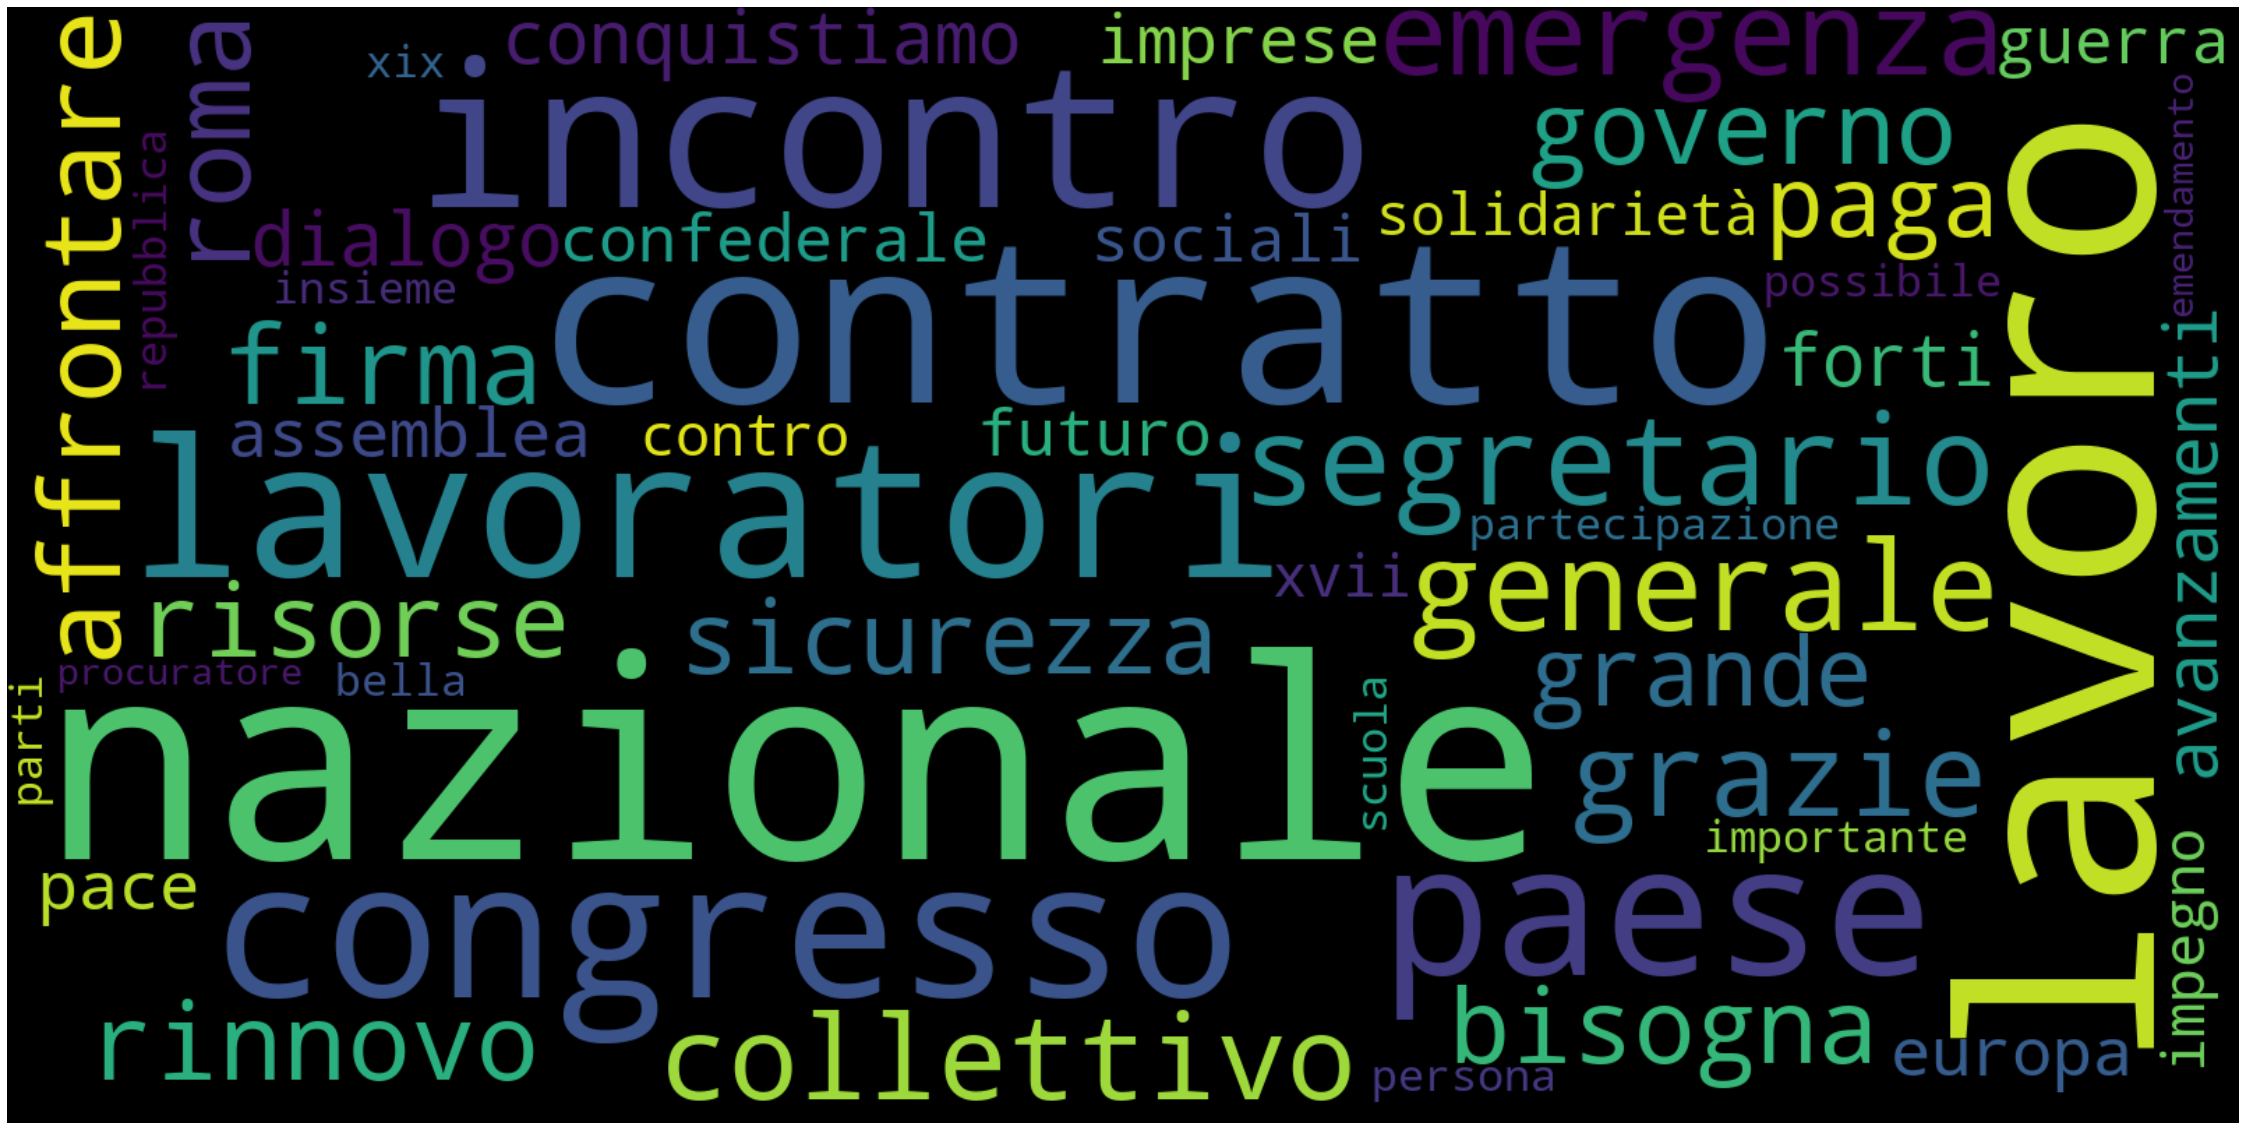

In [ ]:
#prima bozza
wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=200,max_words=50,collocations=False, background_color='black').generate(words)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()  